In [57]:
import pandas as pd
HUNDRED = 100

In [58]:
TRAIN_PATH = 'DATA/TrainData.csv'
MINI_TRAIN_PATH = 'DATA/MiniTrain.csv'
DATA = 'DATA/data.csv'

data = pd.read_csv(DATA)

In [59]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Category'].unique()

array(['tech', 'sport', 'entertainment', 'politics', 'business'],
      dtype=object)

In [60]:
# Dividing the data into train and test set
from sklearn.model_selection import train_test_split
X_train = data
y_train = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20)

print("NUMBER OF DATA POINTS IN TRAIN DATA :", X_train.shape[0])
print("NUMBER OF DATA POINTS IN TEST DATA  :", X_test.shape[0])

NUMBER OF DATA POINTS IN TRAIN DATA : 45572
NUMBER OF DATA POINTS IN TEST DATA  : 11393


In [61]:
from sklearn.feature_extraction.text import CountVectorizer

text_vectorizer = CountVectorizer()
train_text_encoded = text_vectorizer.fit_transform(X_train['Text'])

train_text_features = text_vectorizer.get_feature_names_out()
train_text_feature_counts = train_text_encoded.sum(axis=0).A1
text_feature_dict = dict(zip(list(train_text_features),train_text_feature_counts))

print("Total Number of Unique Words in Train Data :",len(train_text_features))

Total Number of Unique Words in Train Data : 36961


In [63]:
for word, frequency in list(text_feature_dict.items()):
    if word[0] >= '0' and word[0] <= '9':
        del text_feature_dict[word]

In [64]:
from sklearn.preprocessing import normalize

train_text_encoded = normalize(train_text_encoded, axis=0)
test_text_encoded = text_vectorizer.transform(X_test['Text'])
test_text_encoded = normalize(test_text_encoded, axis=0)

In [65]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
HUNDRED = 100
cv_log_error_array = []

for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text_encoded, y_train)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_encoded, y_train)
    
    sig_clf_probs = nb_sig_clf.predict_proba(test_text_encoded)
    
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))

best_alpha = np.argmax(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_encoded, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_encoded, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_encoded)
print('For values of best alpha =', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-6))

predict_y = nb_sig_clf.predict_proba(test_text_encoded)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-6))

For values of best alpha = 1000 The train log loss is: 0.8198258617134212
For values of best alpha = 1000 The cross validation log loss is: 1.117515568239359


In [66]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

clf = MultinomialNB(alpha=0.1)
clf.fit(train_text_encoded, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_encoded, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_encoded)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-6))

predict_y = nb_sig_clf.predict_proba(test_text_encoded)
print("The cross validation log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-6))

The train log loss is: 0.5881960722139208
The cross validation log loss is: 0.826450919572044


In [67]:
from sklearn.metrics import accuracy_score
y_pred = nb_sig_clf.predict(test_text_encoded)
# train_accuracy = (nb_sig_clf.score(train_text_encoded, y_train)*HUNDRED)
cv_accuracy = (accuracy_score(y_pred, y_test)*HUNDRED)

In [68]:
print("Naive Bayes CV Accuracy -",cv_accuracy)

Naive Bayes CV Accuracy - 70.6047573071184


In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<Axes: >

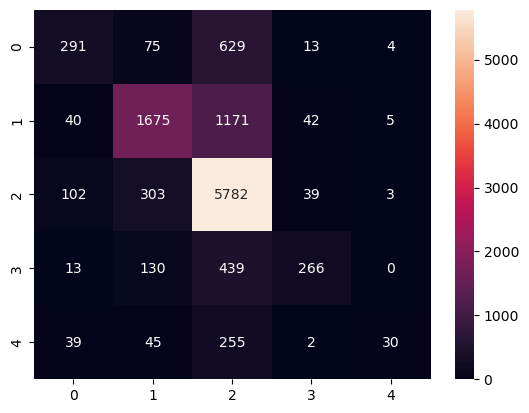

In [70]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
# conf_mat